# Features engineering

Transforming the enough raw data in the format depending on the selected model. This is the art of ML, when expertise matters and what most applied ML learning engineers do.

In [1]:
# Add local modules
import sys
import os

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

## Missing data

## Dimensionality reduction

Why? the more data the more computation needed (not linearly!) and eventually more noise. Therefore, we need to remove the noise and select what has information.

Below an exaple to use PCA within a ML pipeline.


In [2]:
# PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest

# Load data
X,y = make_classification(n_informative=5, n_redundant=2, n_repeated=2,\
                          n_classes=4, n_clusters_per_class=2)

# Define steps
pca = PCA(n_components=2)
selection = SelectKBest(k=1)
combined_features = FeatureUnion([("pca", pca), ("select", selection)])
classifier = RandomForestClassifier()

# Grid search 
n_components = [1, 3, 5, 10]
select_k=[1, 3, 5, 10]
pipeline = Pipeline([("features", combined_features), ("classifier", classifier)])
param_grid = dict(features__pca__n_components=n_components,
                  features__select__k=select_k)

grid_search = GridSearchCV(pipeline, param_grid=param_grid).fit(X, y)


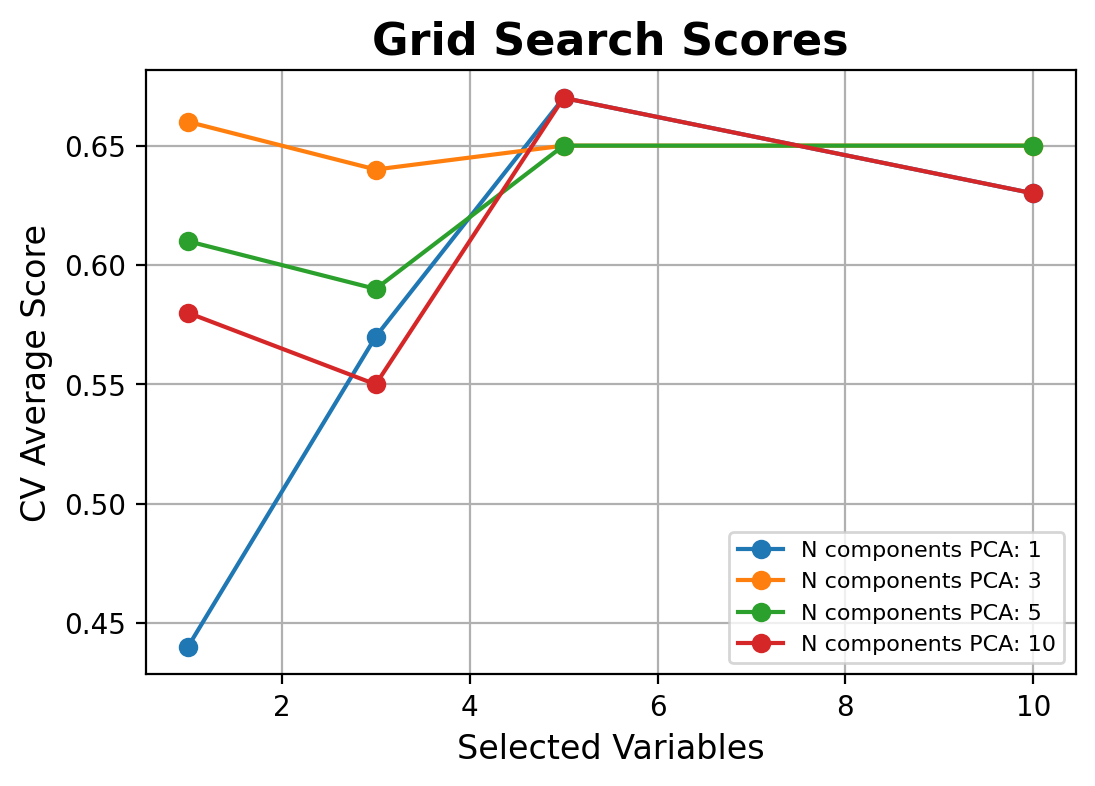

In [3]:
from src.data_analysis import plot_grid_search

plot_grid_search(grid_search.cv_results_, [n_components, select_k], ['N components PCA', 'Selected Variables'])

## Outliers

## Unbalanced datasets